# YOLO Object Tracking Test 

This notebook explores the possiblity of making use of the YOLO algorithm to perform tracking of the mouse moving within a maze. 

YOLO is a machine learning model designed to perform real-time object localization and detection and is widely used for a variety of computer vision based tasks. It's well known for its impressive speed and accuracy, and ease of use. 

In this experiment, we use YOLO v8.2 to perform image localization. This is the process of identifying a set of two points on the image, known as the bounding box, which surround an object within the image. 

In [1]:
import numpy as np 
import cv2 
from tqdm import trange
import matplotlib.pyplot as plt 
import ultralytics 
from ultralytics import YOLO
import wandb
import torch

import os 
from typing import Tuple, Optional
import datetime 


VIDEO_PATH = "/Users/henrywilliams/Downloads/videos/maze_test.mp4" 
WANDB_SILENT = True
TRAIN = False

if TRAIN: 
    from wandb.integration.ultralytics import add_wandb_callback 

    os.environ["WANDB_SILENT"] = WANDB_SILENT

    wandb.login()
    wandb.init(
        project="mice-maze",
        job_type="training",
        entity="lainon",
        name="yolov8 for mouse tracking",
        notes="Using larger dataset (n=595), with random rotation of images"
    )

yolo = YOLO()
cap = cv2.VideoCapture(VIDEO_PATH)
n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

print("VIDEO INFORMATION: ")
print("x\t\ty\t\tfps")
print(f"{cap.get(cv2.CAP_PROP_FRAME_WIDTH)}\t\t{cap.get(cv2.CAP_PROP_FRAME_HEIGHT)}\t\t{cap.get(cv2.CAP_PROP_FPS)}")
print(f"Video Duration:\t\t\t{datetime.timedelta(seconds=(cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)))}")

VIDEO INFORMATION:

x               y               fps

260.0           260.0           30.0

Video Duration:                 0:45:12.233333

# Create a Dataset

The following code cell takes 250 random frames from the video capture, and saves them to the `./frames/` directory. These frames are later annotated and used to fine-tune the YOLO model. To change where the frames are saved, modify the `OUTPUT_DIR` variable, and in order to change the number of samples captured, modify the `TOTAL_SAMPLES` variable. 

In [2]:
TOTAL_SAMPLES = 250
OUTPUT_DIR = './frames'

def get_nth_frame(cap: cv2.VideoCapture, n: int, n_frames: Optional[int] = None) -> np.ndarray: 
    """
    Retrieve the nth frame from a video capture object.

    This function extracts the nth frame from a given video capture object `cap`. 
    If `n_frames` is not provided, the function will determine the total number of frames 
    in the video. The frame counter is reset to its last value before the nth frame was 
    retrieved

    Parameters:
    cap (cv2.VideoCapture): The video capture object from which to extract the frame.
    n (int): The frame number to retrieve.
    n_frames (Optional[int], optional): The total number of frames in the video. 
                                        If not provided, it will be determined automatically.

    Returns:
    np.ndarray: The nth frame as an array.

    Raises:
    IndexError: If `n` exceeds the total number of frames available in the video.
    RuntimeError: If the frame could not be read from the video capture object.

    Example usage:
    >>> cap = cv2.VideoCapture('video.mp4')
    >>> frame = get_nth_frame(cap, 10)
    >>> cv2.imshow('10th Frame', frame)
    >>> cv2.waitKey(0)
    >>> cv2.destroyAllWindows()
    """
    n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) if n_frames is None else n_frames
    current_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)

    if n > n_frames: 
        raise IndexError(f"Attempted to get {n}th frame when only {n_frames} frames exist")
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, n)
    
    ret, frame = cap.read()
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

    if not ret: 
        raise RuntimeError(f"Failed to read {n}th frame")
    
    return frame 


for i in trange(TOTAL_SAMPLES):
    if os.path.exists(OUTPUT_DIR):
        print("Data already gathered, exiting...")
        break
    n = np.random.randint(0, n_frames)
    frame = get_nth_frame(cap, n, n_frames=n_frames)
    cv2.imwrite(f"./frames/frame-{n}.jpg", frame)

  0%|          | 0/250 [00:00<?, ?it/s]

Data already gathered, exiting...

  0%|          | 0/250 [00:00<?, ?it/s]


## Annotation 

Please visit [roboflow](https://universe.roboflow.com/mice-maze/mice-maze) to view and download the annotated dataset. Ensure the dataset is in the same format as the following. 

    mice-maze-dataset
    ├── data.yaml
    ├── images
    │   ├── test
    │   ├── train
    │   └── val
    └── labels
        ├── test
        ├── train
        └── val

You may also need to edit the `data.yaml` file in order to get the data set working correctly. Here is an example of such a file 

```yaml
path: /path/to/mice-maze-dataset
train: images/train  # Path to training images
val: images/val  # Path to validation images
test: images/test  # Path to test images

# Class names (you can add more if you have more classes)
names:
    0: mouse
```

## Fine-tuning the model

In [3]:
# Select the best backend to train the model on 
# If no such backend is available, such as a CUDA-enabled 
# GPU, found in modern Nvidia cards, or MPS found in 
# Apple devices with an Apple Silicon CPU (M1, M2, etc), 
# make use of the CPU 
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_built():
    # NOTE: See https://github.com/ultralytics/ultralytics/issues/12999
    device = torch.device('mps')
else: 
    print("No backend availale, defaulting to CPU")
    print("This might take a while, please ensure you installed the correct version of pytorch for your hardware")
    print("Please see `https://pytorch.org/get-started/locally/`")
    device = torch.device('cpu')

if TRAIN: 
    yolo = ultralytics.YOLO('yolov8n.pt')
    add_wandb_callback(yolo, enable_model_checkpointing=True)
    yolo.train(data="Mice-Maze-2/data.yaml", device=device, epochs=100)
    wandb.finish()
else: 
    print("Model already trained, loading...")

Model already trained, loading...

# Real-World Performance of the Model 

Use the best performing model from training on the test video to find the path of the mouse takes through the maze. Save the 

In [4]:
trained_yolo = ultralytics.YOLO("/Users/henrywilliams/Documents/programming/python/mice-maze-rewrite/yolo-test/runs/detect/train40/weights/best.pt")
path_name = "path_xywh_v1.npy"
if not os.path.exists(path_name):
    path = trained_yolo.track(VIDEO_PATH, persist=True)
    path_xywh = np.empty((len(path), 4))
    for i, result in enumerate(path):
        if result.names != {0: 'mouse'}:
            print("No mouse found in this frame")
            continue 

        if len(result.boxes.xywh) == 0:
            continue

        x, y, w, h = result.boxes.xywh.tolist()[0]
        path_xywh[i] = np.array([x, y, w, h])
    np.save(path_name, path_xywh)
else: 
    path_xywh = np.load(path_name)

In [5]:
def get_bbox_midpoint(x: float, y: float, w: float, h: float) -> Tuple[float, float]:
    x_midpoint = x + (w / 2)
    y_midpoint = y + (h / 2)
    
    # return (x_midpoint, y_midpoint)
    return x, y


path_xy = np.apply_along_axis(lambda bbox: get_bbox_midpoint(*bbox), axis=1, arr=path_xywh)

# Data Postprocessing 

Upon extracting the locations of the mice within the maze, we see that there are a few anomolous data points which need to be removed from the dataset. The following cells will demonstrate how invalid elements are detected and removed. 

In [6]:
def plot_data(path: np.ndarray, cap, ax, title: Optional[str] = None, **kwargs):
    bg_image = cv2.cvtColor(get_nth_frame(cap, 30), cv2.COLOR_BGR2RGB)
    w, h, _ = bg_image.shape
    xs = path[:, 0]
    ys = path[:, 1]

    heatmap, _, _ = np.histogram2d(
        xs, ys,
        bins=(w, h),
        range=[[0, w], [0, h]]
    )

    heatmap = np.log1p(heatmap.T)
    heatmap /= heatmap.max()

    alpha_mask = np.zeros_like(heatmap)
    alpha_mask[heatmap > 0] = 1

    if title is not None:
        ax.set_title(title)

    ax.imshow(bg_image, extent=[0, w, 0, h])
    ax.imshow(heatmap, alpha=alpha_mask, vmin=0, vmax=1, zorder=2, interpolation="nearest", **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlim(0, w)
    ax.set_ylim(0, h)
    ax.invert_yaxis()

## Values out of expected range

As the image of the mouse has a resolution of only 260x260, any values outside of the range 0 < n < 260 can be removed. Furthermore, any elements which contain missing values such as NaN are also removed.  

Removed 38.96% of elements

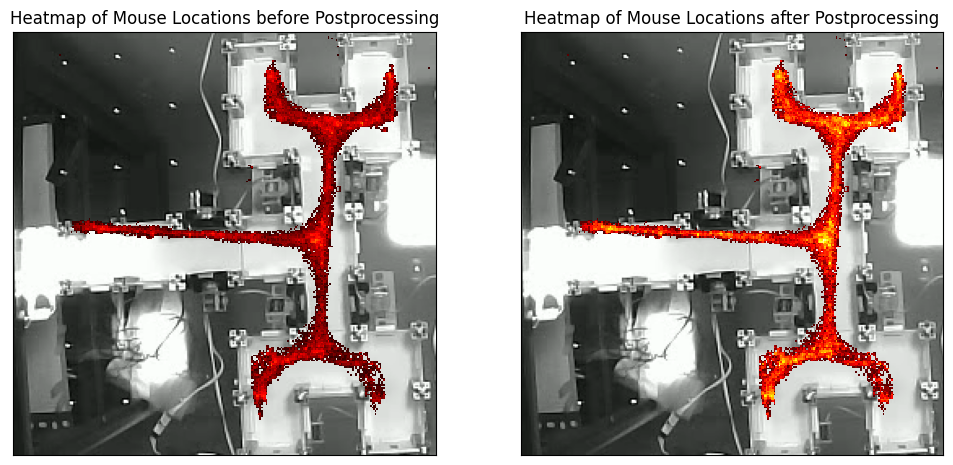

In [7]:
%matplotlib inline

MIN_THRESHOLD = 0
MAX_THRESHOLD = 260

def postprocess_data(path: np.ndarray, min: int, max: int, display_stats: bool = False, remove_nans: bool = True) -> np.ndarray: 
    pre_filtering_length = len(path)

    mask_x = [not (min < x < max) for x in path[:, 0]]
    mask_y = [not (min < y < max) for y in path[:, 1]]

    nan_mask = np.isnan(path_xy).any(axis=1)

    combined_xy_thresh = np.logical_or(mask_x, mask_y)
    combined_mask = np.logical_or(combined_xy_thresh, nan_mask)

    filtered_path = path[~combined_mask if remove_nans else ~combined_xy_thresh]

    post_filtering_length = len(filtered_path)
    percentage_lost = ((pre_filtering_length - post_filtering_length) / pre_filtering_length) * 100

    if display_stats:
        print(f"Removed {percentage_lost:.2f}% of elements")

    return filtered_path

post_proc_path = postprocess_data(path_xy, MIN_THRESHOLD, MAX_THRESHOLD, display_stats=True, remove_nans=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_data(path_xy, cap, axs[0], cmap="hot", title="Heatmap of Mouse Locations before Postprocessing")

plot_data(post_proc_path, cap, axs[1], cmap="hot", title="Heatmap of Mouse Locations after Postprocessing")
plt.show()